# KC Housing Data Evaluation

In [81]:
#Import the relevant packages into notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.ticker import FuncFormatter
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

In [3]:
# Used in converting x and y axis ticks.

def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

formatter = FuncFormatter(millions)

Upload the data into the notebook and examine it

In [4]:
kc_house_data=pd.read_csv('data/kc_house_data.csv')

In [5]:
kc_house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [6]:
kc_house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [7]:
kc_house_data.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

<AxesSubplot:>

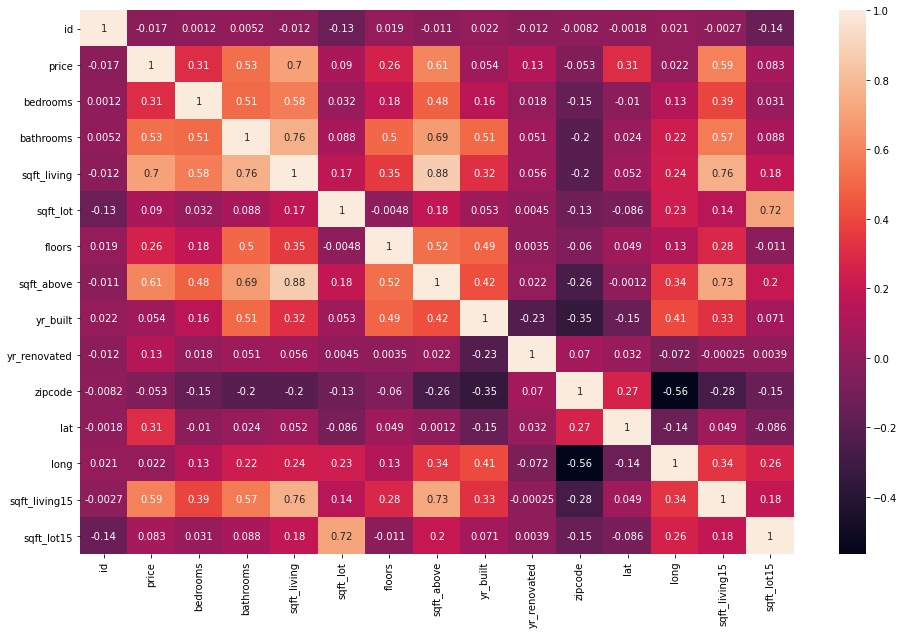

In [8]:
# Seaborn heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(data=kc_house_data.corr(), annot=True)

Examine the missing data in Waterfront and decide what to do with it



In [9]:
kc_house_data['waterfront'].value_counts()

NO     19075
YES      146
Name: waterfront, dtype: int64

In [10]:
# Converting all NANs in waterfront to NO because that is overwhelmingly the most common value.
kc_house_data['waterfront']=kc_house_data['waterfront'].fillna('NO')

In [11]:
kc_house_data['waterfront'].value_counts()

NO     21451
YES      146
Name: waterfront, dtype: int64

In [12]:
kc_house_data['waterfront'].isna().sum()

0

In [13]:
kc_house_data['view'].value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

In [14]:
# Converting all NANs in view to NONE because that is overwhelmingly the most common value.
kc_house_data['view']=kc_house_data['view'].fillna('NONE')
kc_house_data['view'].isna().sum()

0

In [15]:
kc_house_data['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [16]:
# Converting all NANs in yr_renovated to 0 because that is overwhelmingly the most common value.
kc_house_data['yr_renovated'].fillna(0.0, inplace=True)
kc_house_data['yr_renovated'].isna().sum()

0

In [17]:
# There are six columns that are in object form
kc_house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     21597 non-null  object 
 9   view           21597 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   21597 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## Waterfront

In [19]:
kc_house_data['waterfront'].value_counts()

NO     21451
YES      146
Name: waterfront, dtype: int64

In [20]:
X1=kc_house_data['waterfront']

In [21]:
#Label encode NO and YES into 0 and 1 for the Waterfront column
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
origin_encoded = lb_make.fit_transform(X1)
origin_encoded
origin_encoded=pd.Series(origin_encoded)
origin_encoded.value_counts()

0    21451
1      146
dtype: int64

In [22]:
#Replace the old categorial series with our numeric one
kc_house_data['waterfront']=origin_encoded

In [23]:
#Check to make sure this worked properly
kc_house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,NONE,...,6 Low Average,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [24]:
X= kc_house_data.drop(['price'],axis=1)
y=kc_house_data['price']

## View

In [25]:
from sklearn.preprocessing import OneHotEncoder
view = OneHotEncoder(sparse=False, handle_unknown='ignore')
X2 = kc_house_data[['view']]
view.fit(X2)
view.transform(X2)
view_array = view.transform(X2)
view_panda = pd.DataFrame(view_array, columns=('View_Average', 'View_Excellent', 'View_Fair', 'View_Good', 'View_None'),
                          index=kc_house_data.index)
kc_house_data = pd.concat([kc_house_data, view_panda], axis=1)
kc_house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,View_Average,View_Excellent,View_Fair,View_Good,View_None
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,NONE,...,98178,47.5112,-122.257,1340,5650,0.0,0.0,0.0,0.0,1.0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,NONE,...,98125,47.7210,-122.319,1690,7639,0.0,0.0,0.0,0.0,1.0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,NONE,...,98028,47.7379,-122.233,2720,8062,0.0,0.0,0.0,0.0,1.0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,NONE,...,98136,47.5208,-122.393,1360,5000,0.0,0.0,0.0,0.0,1.0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,NONE,...,98074,47.6168,-122.045,1800,7503,0.0,0.0,0.0,0.0,1.0


In [26]:
kc_house_data.drop('view', axis=1, inplace=True)
kc_house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,...,zipcode,lat,long,sqft_living15,sqft_lot15,View_Average,View_Excellent,View_Fair,View_Good,View_None
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,Average,...,98178,47.5112,-122.257,1340,5650,0.0,0.0,0.0,0.0,1.0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,Average,...,98125,47.7210,-122.319,1690,7639,0.0,0.0,0.0,0.0,1.0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,Average,...,98028,47.7379,-122.233,2720,8062,0.0,0.0,0.0,0.0,1.0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,Very Good,...,98136,47.5208,-122.393,1360,5000,0.0,0.0,0.0,0.0,1.0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,Average,...,98074,47.6168,-122.045,1800,7503,0.0,0.0,0.0,0.0,1.0


## Condition

In [27]:
condition = OneHotEncoder(sparse=False, handle_unknown='ignore')
X3 = kc_house_data[['condition']]
condition.fit(X3)
condition.transform(X3)
condition_array = condition.transform(X3)
condition_panda = pd.DataFrame(condition_array, columns= ('AvgCond','FairCond','GoodCond','PoorCond','VeryGoodCond'), 
                               index=kc_house_data.index)
kc_house_data = pd.concat([kc_house_data, condition_panda], axis=1)
kc_house_data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,...,View_Average,View_Excellent,View_Fair,View_Good,View_None,AvgCond,FairCond,GoodCond,PoorCond,VeryGoodCond
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,Average,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,Average,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,Average,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,Very Good,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,Average,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,0,Average,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,0,Average,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0,Average,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,0,Average,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [28]:
kc_house_data.drop('condition', axis=1, inplace=True)
kc_house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,...,View_Average,View_Excellent,View_Fair,View_Good,View_None,AvgCond,FairCond,GoodCond,PoorCond,VeryGoodCond
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,7 Average,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,7 Average,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,6 Low Average,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,7 Average,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,8 Good,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


# Sqft Basement

In [29]:
kc_house_data["sqft_basement"].replace({"?": '0.0'}, inplace=True)
kc_house_data['sqft_basement'] = kc_house_data['sqft_basement'].astype(float)

In [31]:
kc_house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              21597 non-null  int64  
 1   date            21597 non-null  object 
 2   price           21597 non-null  float64
 3   bedrooms        21597 non-null  int64  
 4   bathrooms       21597 non-null  float64
 5   sqft_living     21597 non-null  int64  
 6   sqft_lot        21597 non-null  int64  
 7   floors          21597 non-null  float64
 8   waterfront      21597 non-null  int32  
 9   grade           21597 non-null  object 
 10  sqft_above      21597 non-null  int64  
 11  sqft_basement   21597 non-null  float64
 12  yr_built        21597 non-null  int64  
 13  yr_renovated    21597 non-null  float64
 14  zipcode         21597 non-null  int64  
 15  lat             21597 non-null  float64
 16  long            21597 non-null  float64
 17  sqft_living15   21597 non-null 

## Grade

In [32]:
kc_house_data['grade'].value_counts()

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

In [33]:
grade = OneHotEncoder(sparse=False, handle_unknown='ignore')
X4 = kc_house_data[['grade']]
grade.fit(X4)
grade.transform(X4)
grade_array = grade.transform(X4)
grade_panda = pd.DataFrame(grade_array, columns= ('VeryGoodGrade','ExcellentGrade','LuxaryGrade','MansionGrade','PoorGrade',
                                                 'LowGrade','FairGrade','LowAvgGrade','AvgGrade',
                                                  'GoodGrade','BetterGrade'),index=kc_house_data.index)
kc_house_data = pd.concat([kc_house_data, grade_panda], axis=1)
kc_house_data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,...,ExcellentGrade,LuxaryGrade,MansionGrade,PoorGrade,LowGrade,FairGrade,LowAvgGrade,AvgGrade,GoodGrade,BetterGrade
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,7 Average,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,7 Average,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,6 Low Average,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,7 Average,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,8 Good,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,0,8 Good,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,0,8 Good,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0,7 Average,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,0,8 Good,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [34]:
kc_house_data.drop(columns=('grade'), inplace=True)

## Date

In [35]:
kc_house_data['date'] = pd.to_datetime(kc_house_data['date'])
kc_house_data['day_sold'] = kc_house_data['date'].map(lambda x: x.day)
kc_house_data['month_sold'] = kc_house_data['date'].map(lambda x: x.month)
kc_house_data['year_sold'] = kc_house_data['date'].map(lambda x: x.year)
kc_house_data.drop('date', axis=1, inplace=True)

In [36]:
kc_house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 41 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              21597 non-null  int64  
 1   price           21597 non-null  float64
 2   bedrooms        21597 non-null  int64  
 3   bathrooms       21597 non-null  float64
 4   sqft_living     21597 non-null  int64  
 5   sqft_lot        21597 non-null  int64  
 6   floors          21597 non-null  float64
 7   waterfront      21597 non-null  int32  
 8   sqft_above      21597 non-null  int64  
 9   sqft_basement   21597 non-null  float64
 10  yr_built        21597 non-null  int64  
 11  yr_renovated    21597 non-null  float64
 12  zipcode         21597 non-null  int64  
 13  lat             21597 non-null  float64
 14  long            21597 non-null  float64
 15  sqft_living15   21597 non-null  int64  
 16  sqft_lot15      21597 non-null  int64  
 17  View_Average    21597 non-null 

# Working with newly cleaned data

In [37]:
# This seems like the better time to do this now that there are no objects left in the data set
from sklearn.model_selection import train_test_split
X_new= kc_house_data.drop(['price'],axis=1)
y_new=kc_house_data['price']
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, random_state=100)

In [38]:
# Create Dummy Regressor
from sklearn.dummy import DummyRegressor
baseline = DummyRegressor(strategy="mean")
baseline.fit(X_train,y_train)
baseline.score(X_test,y_test)

-0.0002252015545449737

In [39]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train,y_train)
linreg.score(X_train,y_train)

0.7315060627312487

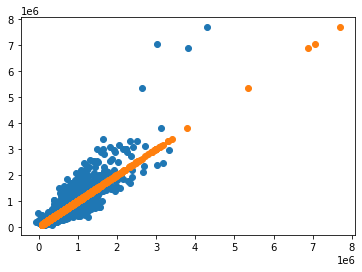

In [40]:
# First look at test prediction
y_test_pred=linreg.predict(X_test)
plt.scatter(y_test_pred,y_test)
plt.scatter(y_test,y_test);

In [41]:
#Get a score
linreg.score(X_test,y_test)

0.7312203494034187

In [42]:
#Try and use RFE to find best values... for now we will look at 3 but choosing that number will need to be evaluated
selector = RFE(linreg, n_features_to_select=3)
selector = selector.fit(X_train, y_train)
selector.support_ 

array([False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False, False])

In [43]:
# Get a model score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
cross_val_score(model, X_train, y_train, cv=3)

array([0.73365398, 0.71819072, 0.71992986])

In [44]:
# Look at the correlations
X_train.corr()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,yr_built,...,PoorGrade,LowGrade,FairGrade,LowAvgGrade,AvgGrade,GoodGrade,BetterGrade,day_sold,month_sold,year_sold
id,1.000000,0.001392,0.003171,-0.010697,-0.130972,0.026625,-0.006095,-0.008229,-0.007013,0.025029,...,-0.005950,-0.001169,-0.028132,-0.013132,-0.018813,0.044579,0.007386,-0.002257,-0.008802,0.008262
bedrooms,0.001392,1.000000,0.509966,0.571611,0.041768,0.174694,-0.009579,0.471756,0.295603,0.152554,...,-0.020080,-0.070759,-0.106809,-0.232743,-0.106995,0.067507,0.161419,-0.012232,0.003773,-0.013338
bathrooms,0.003171,0.509966,1.000000,0.754862,0.092054,0.501498,0.056757,0.685377,0.278308,0.509144,...,-0.013970,-0.057950,-0.139281,-0.361788,-0.318158,0.189152,0.265665,-0.008065,0.007403,-0.024851
sqft_living,-0.010697,0.571611,0.754862,1.000000,0.175679,0.349225,0.097980,0.874879,0.430163,0.320791,...,-0.013416,-0.057001,-0.124387,-0.310274,-0.362749,0.068887,0.319427,-0.011902,0.010998,-0.028839
sqft_lot,-0.130972,0.041768,0.092054,0.175679,1.000000,-0.011335,0.023104,0.184937,0.018280,0.049333,...,-0.000420,0.000451,0.022915,-0.016425,-0.067733,-0.022685,0.043823,-0.001736,-0.001677,0.005769
floors,0.026625,0.174694,0.501498,0.349225,-0.011335,1.000000,0.016779,0.520579,-0.243201,0.495012,...,-0.007202,-0.030699,-0.079204,-0.230616,-0.311691,0.206585,0.242334,-0.007617,0.013139,-0.022651
waterfront,-0.006095,-0.009579,0.056757,0.097980,0.023104,0.016779,1.000000,0.064675,0.081447,-0.021540,...,-0.000650,-0.003050,0.020444,-0.005735,-0.046596,-0.011817,0.005842,0.011719,0.011761,-0.009991
sqft_above,-0.008229,0.471756,0.685377,0.874879,0.184937,0.520579,0.064675,1.000000,-0.053381,0.428343,...,-0.012102,-0.050587,-0.105895,-0.280190,-0.390688,0.060609,0.341678,-0.005664,0.011408,-0.026744
sqft_basement,-0.007013,0.295603,0.278308,0.430163,0.018280,-0.243201,0.081447,-0.053381,1.000000,-0.131537,...,-0.005095,-0.023153,-0.058623,-0.117263,-0.021503,0.030224,0.021234,-0.014113,0.002513,-0.009495
yr_built,0.025029,0.152554,0.509144,0.320791,0.049333,0.495012,-0.021540,0.428343,-0.131537,1.000000,...,-0.013696,-0.044276,-0.130624,-0.308188,-0.219266,0.201124,0.219234,-0.003529,-0.011228,0.005441


<AxesSubplot:>

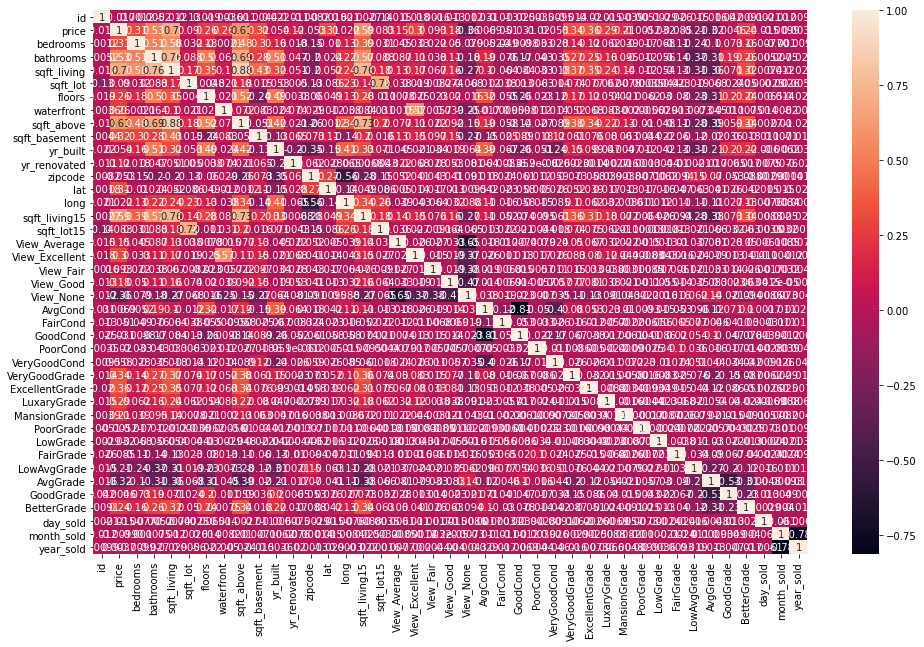

In [45]:
plt.figure(figsize=(16, 10))
sns.heatmap(data=kc_house_data.corr(), annot=True)

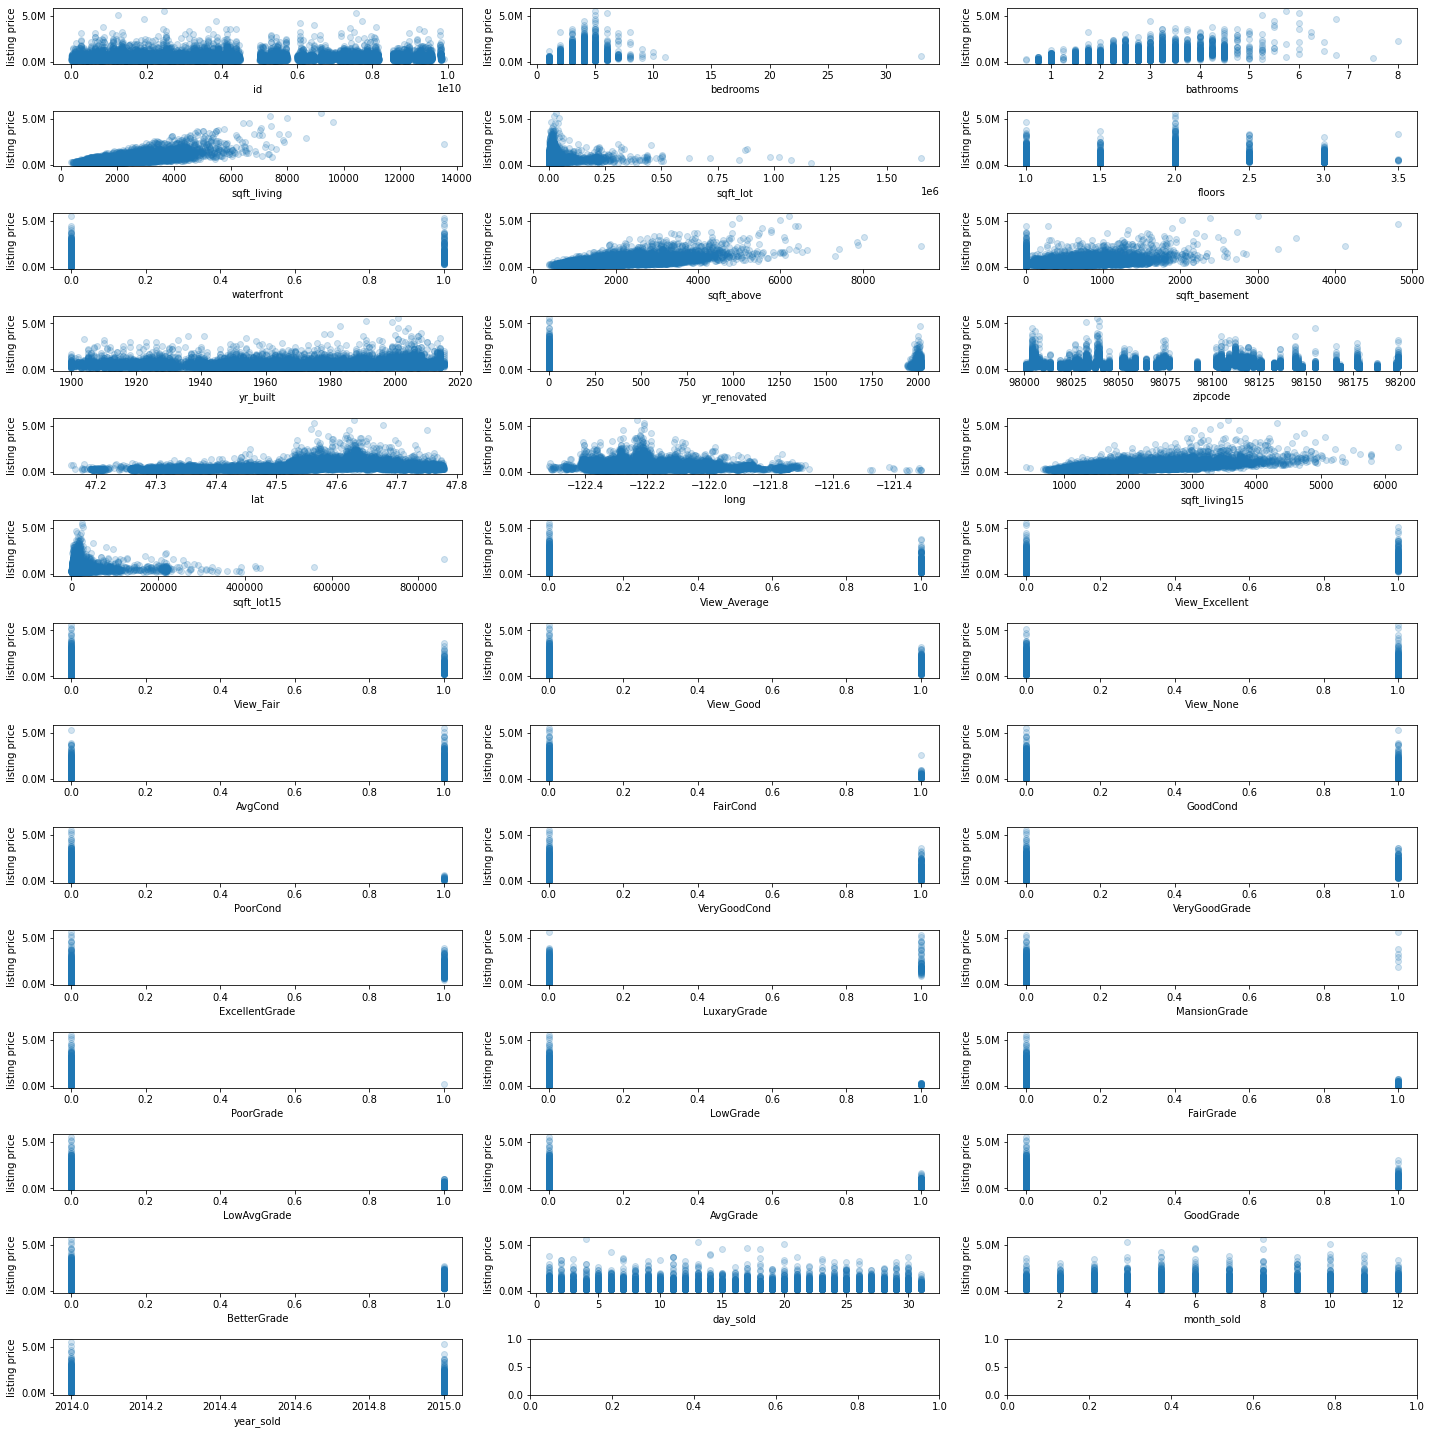

In [53]:
fig, axes = plt.subplots(ncols=3, nrows=14, figsize=(20, 20))
fig.set_tight_layout(True)

for index, col in enumerate(X_train.columns):
    ax = axes[index//3][index%3]
    ax.yaxis.set_major_formatter(formatter)
    ax.scatter(X_train[col], y_train, alpha=0.2)
    ax.set_xlabel(col)
    ax.set_ylabel("listing price")

There's some obvious ones that we can drop that aren't telling us anything like View_Average

In [58]:
X_train_second_model = X_train.drop(["waterfront", "zipcode", "yr_renovated", "View_Average", "View_Excellent", "View_Fair", "id",
                                     "View_Good","View_None","AvgCond","FairCond","GoodCond","PoorCond","VeryGoodCond",
                                    "VeryGoodGrade","ExcellentGrade","LuxaryGrade","MansionGrade","PoorGrade",
                                    "LowGrade","FairGrade","LowAvgGrade","AvgGrade","GoodGrade","BetterGrade", "month_sold","year_sold","day_sold"], axis=1).copy()


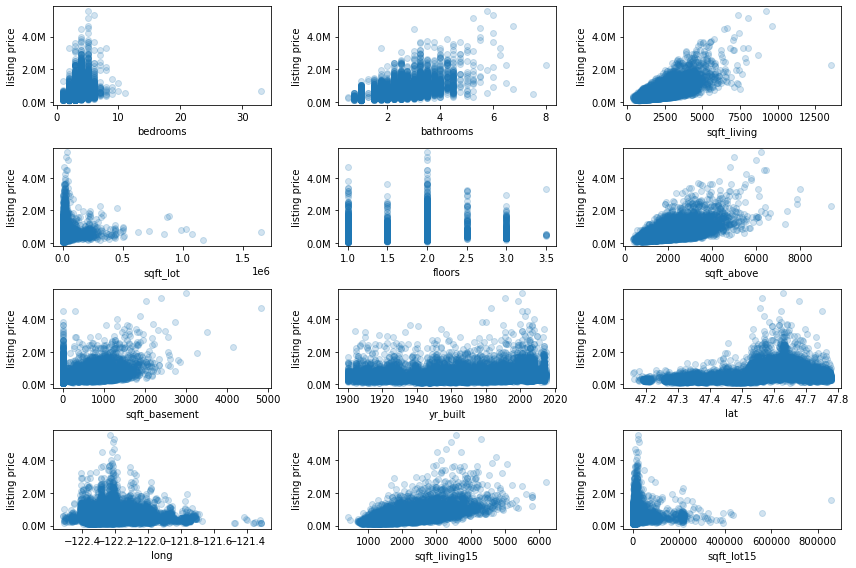

In [60]:
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(12, 8))
fig.set_tight_layout(True)

for index, col in enumerate(X_train_second_model.columns):
    ax = axes[index//3][index%3]
    ax.yaxis.set_major_formatter(formatter)
    ax.scatter(X_train_second_model[col], y_train, alpha=0.2)
    ax.set_xlabel(col)
    ax.set_ylabel("listing price")

<AxesSubplot:>

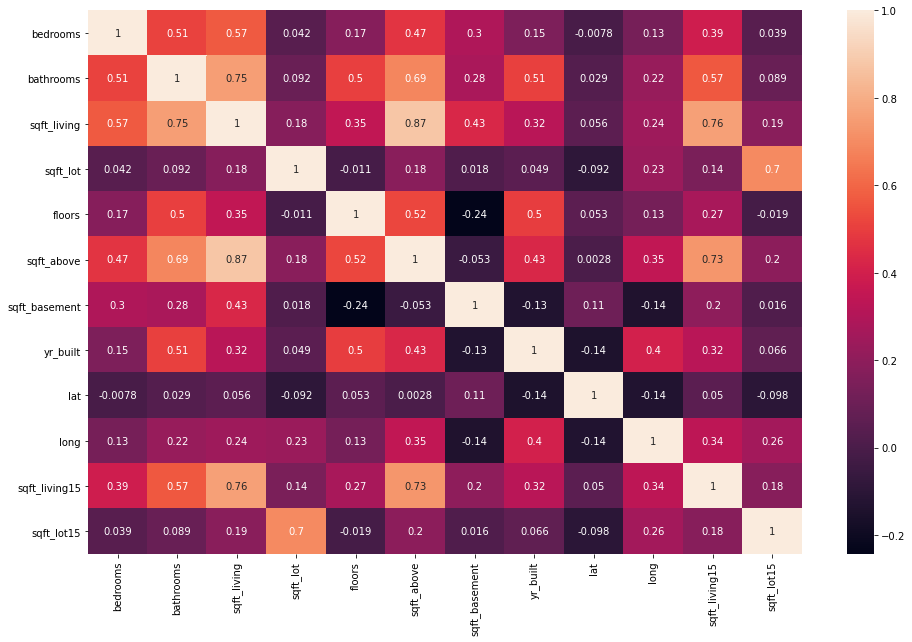

In [62]:
plt.figure(figsize=(16, 10))
sns.heatmap(data=X_train_second_model.corr(), annot=True)

In [68]:
baseline_model = LinearRegression()
second_model = LinearRegression()

splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)

#The baseline model is only using the sqft_living condition
baseline_scores = cross_validate(
    estimator=baseline_model,
    X=X_train[["sqft_living"]],
    y=y_train,
    return_train_score=True,
    cv=splitter
)

second_model_scores = cross_validate(
    estimator=second_model,
    X=X_train_second_model,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Current Model")
print("Train score:     ", second_model_scores["train_score"].mean())
print("Validation score:", second_model_scores["test_score"].mean())
print()
print("Baseline Model")
print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Current Model
Train score:      0.6255920621890159
Validation score: 0.6190474745537438

Baseline Model
Train score:      0.49818030394431956
Validation score: 0.4832176135943374


In [85]:
x_cols2=X_train_second_model.columns
outcome='price'
predictors2='+'.join(x_cols2)
formula2= outcome + '~' + predictors2
new_model = ols(formula=formula2, data=kc_house_data).fit()
new_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     2968.
Date:                Wed, 17 Nov 2021   Prob (F-statistic):               0.00
Time:                        14:53:17   Log-Likelihood:            -2.9687e+05
No. Observations:               21597   AIC:                         5.938e+05
Df Residuals:                   21584   BIC:                         5.939e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -5.385e+07   1.72e+06    -31.275      0.000   -5.72e+07   -5.05e+07
bedrooms      -5.681e+04   2091.581    -27.163      0.000   -6.09e+04   -5.27e+04
bathrooms      6.405e+04   3613.180     17.727      0.000     5.7e+04    7.11e+04
sqft_living     177.4152     20.217      8.776      0.000     137.789     217.042
sqft_lot          0.1881      0.054      3.504      0.000       0.083       0.293
floors          1.98e+04   3985.797      4.967      0.000     1.2e+04    2.76e+04
sqft_above       77.3500     20.231      3.823      0.000      37.695     117.005
sqft_basement    45.7094     20.080      2.276      0.023       6.352      85.067
yr_built      -2457.9673     71.263    -34.492      0.000   -2597.648   -2318.287
lat            5.841e+05   1.15e+04     50.684      0.000    5.62e+05    6.07e+05
long          -2.519e+05   1.31e+04    -19.223      0.000   -2.78e+05   -2.26e+05
sqft_living15    91.9281      3.620     25.395      0.000      84.833      99.023
sqft_lot15       -0.4047      0.082     -4.922      0.000      -0.566      -0.244
==============================================================================
Omnibus:                    17532.654   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1151848.565
Skew:                           3.450   Prob(JB):                         0.00
Kurtosis:                      38.106   Cond. No.                     5.67e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.67e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [72]:
# Importances are based on coefficient magnitude, so
# we need to scale the data to normalize the coefficients
X_train_for_RFECV = StandardScaler().fit_transform(X_train_second_model)

model_for_RFECV = LinearRegression()

# Instantiate and fit the selector
selector = RFECV(model_for_RFECV, cv=splitter)
selector.fit(X_train_for_RFECV, y_train)

# Print the results
print("Was the column selected?")
for index, col in enumerate(X_train_second_model.columns):
    print(f"{col}: {selector.support_[index]}")

Was the column selected?
bedrooms: True
bathrooms: True
sqft_living: True
sqft_lot: True
floors: True
sqft_above: True
sqft_basement: True
yr_built: True
lat: True
long: True
sqft_living15: True
sqft_lot15: True


In [86]:
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test3 = sms.jarque_bera(new_model.resid)
list(zip(name, test3))

[('Jarque-Bera', 1151848.565210786),
 ('Prob', 0.0),
 ('Skew', 3.4498044445522678),
 ('Kurtosis', 38.10562512476082)]